<h1 align="center">UST, Zewail City</h1>
<h2 align="center">CIE 555 (Spring 2021)</h2>
<h2 align="center">Lab 2 part 2: Neural Networks for Regression</h2>


#Installation and import statements

In [1]:
!pip install pandas-profiling==2.7.1

     |████████████████████████████████| 256kB 17.3MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 1.1MB 41.9MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 3.2MB 43.1MB/s 
     |████████████████████████████████| 296kB 43.4MB/s 
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107413 sha256=038986dcab8deeffefc48608fab82595f4c2b1e9281cd9949aee4612fb1a4830
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85653789e80e966c3bf6
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27085 sha256=2d2d87626f2b9ba18b56a5ce15012d078ee4255986598379c0cb374a1412668c
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built phik htmlmin
ERROR: phik 0.11.2 has requirement scipy>=1.5.2, but you'll have scipy 1.4.1 which is incompatible.
  Found existing i

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import pandas_profiling as pp
from pandas_profiling import ProfileReport

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Dense

#Dataset

The dataset used in this lab is Auto MPG Dataset. We will build a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. The features include attributes like: cylinders, displacement, horsepower, and weight. The target variable is MPG. MPG, or miles per gallon, is the distance, measured in miles, that a car can travel per gallon of fuel.

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight','Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_table.html 

In [4]:
dataset = raw_dataset.copy()
dataset.tail()

MPG  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
393  27.0          4         140.0  ...          15.6          82       1
394  44.0          4          97.0  ...          24.6          82       2
395  32.0          4         135.0  ...          11.6          82       1
396  28.0          4         120.0  ...          18.6          82       1
397  31.0          4         119.0  ...          19.4          82       1

[5 rows x 8 columns]

##Exploratory data analysis

In [5]:
pp.ProfileReport(dataset)

Summarize dataset:   0%|          | 0/20 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
#Drop the 6 missing values in horsepower
dataset = dataset.dropna()

In [7]:
#One hot encode thee categorical variable 'Origin'
dataset= pd.get_dummies(dataset, columns= ['Origin'], prefix='Origin', drop_first=False)
dataset.head()

MPG  Cylinders  Displacement  ...  Origin_1  Origin_2  Origin_3
0  18.0          8         307.0  ...         1         0         0
1  15.0          8         350.0  ...         1         0         0
2  18.0          8         318.0  ...         1         0         0
3  16.0          8         304.0  ...         1         0         0
4  17.0          8         302.0  ...         1         0         0

[5 rows x 10 columns]

In [9]:
#Splitting the data to train and validation 

x_data= dataset.drop(columns=['MPG'], axis=1)
y_data= dataset['MPG']
train_features,val_features, train_targets,val_targets=train_test_split(x_data,y_data,test_size=0.2)
train_targets= np.array(train_targets).reshape(-1,1)
val_targets= np.array(val_targets).reshape(-1,1)

#Feature and target scaling
feature_scaler= StandardScaler().fit(train_features)
train_features= feature_scaler.transform(train_features)
val_features= feature_scaler.transform(val_features)

target_scaler= StandardScaler().fit(train_targets)
train_targets=target_scaler.transform(train_targets)
val_targets=target_scaler.transform(val_targets)

#Tensorflow model

A model is, abstractly:
* A function that computes something on tensors (a forward pass)
* Some variables that can be updated in response to training

Most models are made of layers. Layers are functions with a known mathematical structure that can be reused and have trainable variables. In TensorFlow, most high-level implementations of layers and models, such as Keras, are built on the same foundational class: tf.Module.

In [10]:
class Dense(tf.Module):
  def __init__(self, in_features, out_features, name=None):
    #Constructor 
    #self: whenever an object calls its method, the object itself is passed as the first argument.
    #Note: The child's __init__() function overrides the inheritance of the parent's __init__() function.
    #To keep the inheritance of the parent's __init__() function, add a call to the parent's __init__() function
    super().__init__(name=name)
    self.w = tf.Variable(
      tf.random.normal([in_features, out_features]), name='w')
    self.b = tf.Variable(tf.zeros([out_features]), name='b')

  def __call__(self, x):
    #object() is shorthand for object.__call__()
    y = tf.matmul(x, self.w) + self.b
    return y

In [11]:
class SequentialModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    self.dense_1 = Dense(in_features=9, out_features=3)
    self.dense_2 = Dense(in_features=3, out_features=1)

  def __call__(self, x):
    x = self.dense_1(x)
    x=tf.nn.relu(x)
    x= self.dense_2(x)
    return x

In [12]:
# You have made a model!
my_model = SequentialModule()

# Call it
print("Model results:", my_model(tf.constant([train_features[0]], dtype= tf.float32)))

Model results: tf.Tensor([[0.]], shape=(1, 1), dtype=float32)


In [13]:
def loss(pred,target):
  return tf.losses.mean_absolute_error(target, pred)

In [20]:
import os
import datetime

X=tf.constant([train_features], dtype= tf.float32) #Convert features to a constant tensor
y=tf.constant([train_targets], dtype= tf.float32)  #Convert targets to a constant tensor
X_val= tf.constant([val_features], dtype= tf.float32) #Convert features to a constant tensor
y_val= tf.constant([val_targets], dtype= tf.float32)  #Convert targets to a constant tensor

my_model = SequentialModule()    #Create a model

#Define hyperparameters
learning_rate=0.1
num_epochs = 30
  
#Define an optimizer 
optimizer = tf.optimizers.Adam( learning_rate )

all_train_loss=[]
all_val_loss= []


#Training loop
for e in range(num_epochs):
    with tf.GradientTape() as tape:
        train_loss = loss(my_model(X), y)
        train_loss_numpy= tf.reduce_mean(train_loss).numpy()
        all_train_loss.append(train_loss_numpy)
        val_loss= loss(my_model(X_val), y_val)
        val_loss_numpy= tf.reduce_mean(val_loss).numpy()
        all_val_loss.append(val_loss_numpy)
    weights= my_model.trainable_variables
    grads= tape.gradient(train_loss, weights)
    optimizer.apply_gradients(zip(grads, weights))
    print("Epoch:", e, "Train loss:", train_loss_numpy, "Validation loss:",val_loss_numpy)

Epoch: 0 Train loss: 3.8281457 Validation loss: 4.1960373
Epoch: 1 Train loss: 3.0221443 Validation loss: 3.3028247
Epoch: 2 Train loss: 2.4777088 Validation loss: 2.638765
Epoch: 3 Train loss: 2.0000498 Validation loss: 2.0508757
Epoch: 4 Train loss: 1.5577793 Validation loss: 1.5246754
Epoch: 5 Train loss: 1.203726 Validation loss: 1.1383355
Epoch: 6 Train loss: 0.9931984 Validation loss: 0.90466017
Epoch: 7 Train loss: 0.94499445 Validation loss: 0.9455062
Epoch: 8 Train loss: 0.95353645 Validation loss: 0.9712124
Epoch: 9 Train loss: 0.94164026 Validation loss: 0.9401612
Epoch: 10 Train loss: 0.87969035 Validation loss: 0.88092256
Epoch: 11 Train loss: 0.8051833 Validation loss: 0.80725956
Epoch: 12 Train loss: 0.7122428 Validation loss: 0.68163896
Epoch: 13 Train loss: 0.64638895 Validation loss: 0.57310957
Epoch: 14 Train loss: 0.6087189 Validation loss: 0.5151821
Epoch: 15 Train loss: 0.5981674 Validation loss: 0.49810338
Epoch: 16 Train loss: 0.6092313 Validation loss: 0.512702

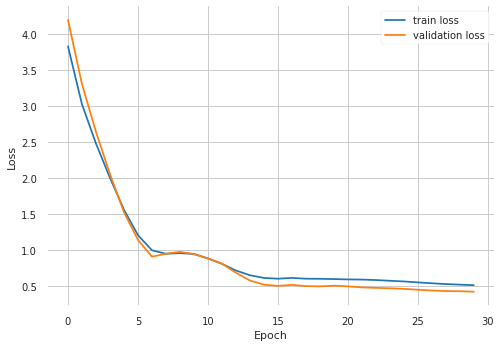

In [21]:
plt.plot(all_train_loss, label='train loss')
plt.plot(all_val_loss, label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#Task

Perform two or more of the following modifications to the above tensorflow model to reach a better performance (lower train and validation losses and a more stable learning/loss curve that doesn't show underfitting or overfitting): 

1. Fine tune the hyperparameters of the above model (i.e number of iterations, learning rate)

2. Experiment with another loss function suitable for the regression task. 

3. Change the optimizer 

4. Change the model architecture (number of layers, activation functions, number of hidden nodes, etc.)

### In this trial I made the following changes:
<ol>
  <li>Added one extra hidden layer to allow my network to better fit the training examples</li>
  <li>Increased the number of epochs to make sure that the model converges</li>
</ol>

### The above changes resulted in a an improved performance as shown in the learning curve below

In [46]:
import os
import datetime

class SequentialModuleModified(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

    self.dense_1 = Dense(in_features=9, out_features=6)
    self.dense_2 = Dense(in_features=6, out_features=6)
    self.dense_3 = Dense(in_features=6, out_features=1)

  def __call__(self, x):
    x = self.dense_1(x)
    x=tf.nn.relu(x)
    x= self.dense_2(x)
    x=tf.nn.relu(x)
    x=self.dense_3(x)
    return x

X=tf.constant([train_features], dtype= tf.float32) #Convert features to a constant tensor
y=tf.constant([train_targets], dtype= tf.float32)  #Convert targets to a constant tensor
X_val= tf.constant([val_features], dtype= tf.float32) #Convert features to a constant tensor
y_val= tf.constant([val_targets], dtype= tf.float32)  #Convert targets to a constant tensor

my_model = SequentialModuleModified()    #Create a model

#Define hyperparameters
learning_rate=0.1
num_epochs = 1500
  
#Define an optimizer 
optimizer = tf.optimizers.Adam(learning_rate )

all_train_loss=[]
all_val_loss= []


#Training loop
for e in range(num_epochs):
    with tf.GradientTape() as tape:
        train_loss = loss(my_model(X), y)
        train_loss_numpy= tf.reduce_mean(train_loss).numpy()
        all_train_loss.append(train_loss_numpy)
        val_loss= loss(my_model(X_val), y_val)
        val_loss_numpy= tf.reduce_mean(val_loss).numpy()
        all_val_loss.append(val_loss_numpy)
    weights= my_model.trainable_variables
    grads= tape.gradient(train_loss, weights)
    optimizer.apply_gradients(zip(grads, weights))
    print("Epoch:", e, "Train loss:", train_loss_numpy, "Validation loss:",val_loss_numpy)

Epoch: 0 Train loss: 4.0002623 Validation loss: 4.0298085
Epoch: 1 Train loss: 2.3849225 Validation loss: 2.5069416
Epoch: 2 Train loss: 1.4977194 Validation loss: 1.5540397
Epoch: 3 Train loss: 0.9525955 Validation loss: 0.9504914
Epoch: 4 Train loss: 0.7648596 Validation loss: 0.7198699
Epoch: 5 Train loss: 0.6825935 Validation loss: 0.61505955
Epoch: 6 Train loss: 0.61444604 Validation loss: 0.5494649
Epoch: 7 Train loss: 0.55572075 Validation loss: 0.49608192
Epoch: 8 Train loss: 0.53374547 Validation loss: 0.46482536
Epoch: 9 Train loss: 0.5377106 Validation loss: 0.46192545
Epoch: 10 Train loss: 0.54312015 Validation loss: 0.46346438
Epoch: 11 Train loss: 0.53428525 Validation loss: 0.449306
Epoch: 12 Train loss: 0.51670015 Validation loss: 0.426722
Epoch: 13 Train loss: 0.4899466 Validation loss: 0.39109558
Epoch: 14 Train loss: 0.45933473 Validation loss: 0.35502633
Epoch: 15 Train loss: 0.42361173 Validation loss: 0.33158824
Epoch: 16 Train loss: 0.40002584 Validation loss: 0.

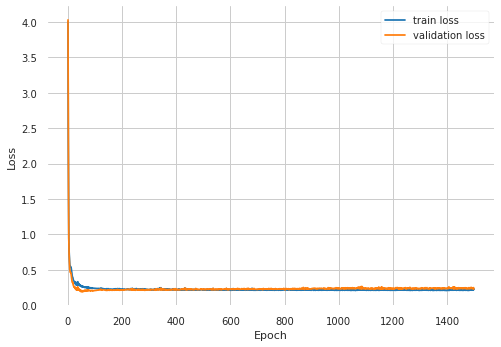

In [47]:
plt.plot(all_train_loss, label='train loss')
plt.plot(all_val_loss, label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

### In this trial I kept the same changes as before, and only changed the optimizer from Adam to Adadelta which implements a stochastic gradient decsent

In [48]:
my_model = SequentialModuleModified()    #Create a model

#Define hyperparameters
learning_rate=0.1
num_epochs = 1500
  
#Define an optimizer 
optimizer = tf.optimizers.Adadelta(learning_rate)

all_train_loss=[]
all_val_loss= []


#Training loop
for e in range(num_epochs):
    with tf.GradientTape() as tape:
        train_loss = loss(my_model(X), y)
        train_loss_numpy= tf.reduce_mean(train_loss).numpy()
        all_train_loss.append(train_loss_numpy)
        val_loss= loss(my_model(X_val), y_val)
        val_loss_numpy= tf.reduce_mean(val_loss).numpy()
        all_val_loss.append(val_loss_numpy)
    weights= my_model.trainable_variables
    grads= tape.gradient(train_loss, weights)
    optimizer.apply_gradients(zip(grads, weights))
    print("Epoch:", e, "Train loss:", train_loss_numpy, "Validation loss:",val_loss_numpy)

Epoch: 0 Train loss: 9.143719 Validation loss: 8.723921
Epoch: 1 Train loss: 9.134864 Validation loss: 8.715667
Epoch: 2 Train loss: 9.125898 Validation loss: 8.707312
Epoch: 3 Train loss: 9.116863 Validation loss: 8.69889
Epoch: 4 Train loss: 9.107775 Validation loss: 8.690419
Epoch: 5 Train loss: 9.098644 Validation loss: 8.681909
Epoch: 6 Train loss: 9.0894785 Validation loss: 8.6733675
Epoch: 7 Train loss: 9.080282 Validation loss: 8.664796
Epoch: 8 Train loss: 9.07106 Validation loss: 8.656202
Epoch: 9 Train loss: 9.061817 Validation loss: 8.64759
Epoch: 10 Train loss: 9.052551 Validation loss: 8.638974
Epoch: 11 Train loss: 9.043268 Validation loss: 8.630341
Epoch: 12 Train loss: 9.033968 Validation loss: 8.621691
Epoch: 13 Train loss: 9.024652 Validation loss: 8.613028
Epoch: 14 Train loss: 9.015324 Validation loss: 8.604352
Epoch: 15 Train loss: 9.005981 Validation loss: 8.595664
Epoch: 16 Train loss: 8.996641 Validation loss: 8.586975
Epoch: 17 Train loss: 8.987291 Validation 

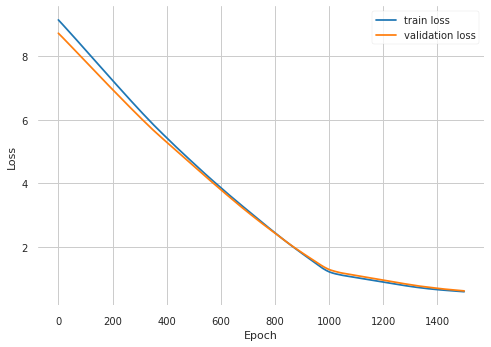

In [49]:
plt.plot(all_train_loss, label='train loss')
plt.plot(all_val_loss, label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#Keras model

In [ ]:
model = keras.Sequential([
    layers.Dense(3, activation = 'relu', input_shape=[train_features.shape[1]]), #Input Layer
    layers.Dense(1) #Output Layer
   ])

# Compile the network :
model.compile(loss = keras.losses.MeanAbsoluteError(), 
                 optimizer = 'adam', metrics = keras.metrics.MeanAbsoluteError())
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 3)                 30        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 4         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_features, train_targets,validation_data=(val_features, val_targets),epochs=30)

Epoch 1/30
10/10 [==============================] - 0s 18ms/step - loss: 1.0108 - mean_absolute_error: 1.0108 - val_loss: 1.0619 - val_mean_absolute_error: 1.0619
Epoch 2/30
10/10 [==============================] - 0s 6ms/step - loss: 0.9840 - mean_absolute_error: 0.9840 - val_loss: 1.0069 - val_mean_absolute_error: 1.0069
Epoch 3/30
10/10 [==============================] - 0s 5ms/step - loss: 0.9535 - mean_absolute_error: 0.9535 - val_loss: 0.9571 - val_mean_absolute_error: 0.9571
Epoch 4/30
10/10 [==============================] - 0s 5ms/step - loss: 0.9220 - mean_absolute_error: 0.9220 - val_loss: 0.9137 - val_mean_absolute_error: 0.9137
Epoch 5/30
10/10 [==============================] - 0s 5ms/step - loss: 0.8315 - mean_absolute_error: 0.8315 - val_loss: 0.8748 - val_mean_absolute_error: 0.8748
Epoch 6/30
10/10 [==============================] - 0s 6ms/step - loss: 0.8596 - mean_absolute_error: 0.8596 - val_loss: 0.8365 - val_mean_absolute_error: 0.8365
Epoch 7/30
10/10 [=========

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

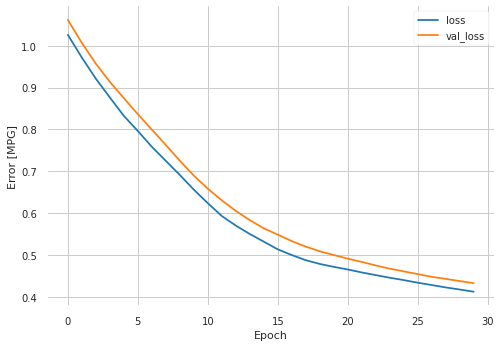

In [ ]:
plot_loss(history)


#References

https://becominghuman.ai/image-classification-with-tensorflow-2-0-without-keras-e6534adddab2

https://www.tensorflow.org/tutorials/keras/regression

https://www.tensorflow.org/guide/basic_training_loops

https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough

https://archive.ics.uci.edu/ml/datasets/auto+mpg
https://www.geeksforgeeks.org/what-is-the-difference-between-__init__-and-__call__/ 

https://pypi.org/project/pandas-profiling/